# Monocle analysis of single-cell sequencing of influenza-infected cells
Study by Alistair Russell, [Cole Trapnell](http://cole-trapnell-lab.github.io/), and [Jesse Bloom](https://research.fhcrc.org/bloom/en.html).

This notebook starts with the annotated cell-gene matrix, and analyzes the expression of influenza-infected cells in various ways. 
It primarily does this using [Monocle](http://cole-trapnell-lab.github.io/monocle-release/)​.

## Setup 
Load or install necessary packages.
Cole suggested that we might want to install the development version of [Monocle](http://cole-trapnell-lab.github.io/monocle-release/) from GitHub; right now this does **not** do this.

In [1]:
# install packages
if (suppressMessages((!require("monocle", quietly=TRUE)))) {
  source("http://bioconductor.org/biocLite.R", suppressUpdates=TRUE)
  biocLite()
  biocLite("monocle", suppressWarnings=TRUE)
}
cat("Using monocle version", package.version("monocle"))
if (!require("pacman", quietly=TRUE)) 
  install.packages("pacman")
pacman::p_load("ggplot2", "ggthemes", "ggExtra", "gridExtra", "cowplot", "scales", "reshape2", 
  "dplyr", "magrittr", "rmarkdown", "IRdisplay", "psych")

# plots will be saved here
plotsdir <- './results/plots/'
if (!dir.exists(plotsdir)) 
  dir.create(plotsdir)    
    
fancy_scientific <- function(x, parse.str=TRUE, digits=NULL) {
  # scientific notation formatting, based loosely on https://stackoverflow.com/a/24241954
  # if `parse.str` is TRUE, then we parse the string into an expression
  # `digits` indicates how many digits to include
  x %>% format(scientific=TRUE, digits=digits) %>% gsub("^0e\\+00","0", .) %>%
    gsub("^1e\\+00", "1", .) %>% gsub("^(.*)e", "'\\1'e", .) %>% 
    gsub("e\\+","e", .) %>% gsub("e", "%*%10^", .) %>%
    gsub("^\'1\'\\%\\*\\%", "", .) %>% {if (parse.str) parse(text=.) else .}
}

Using monocle version 2.4.0

## Create cell-gene dataset and examine basic statistics 
Read in cell-gene data for all samples.
This is the merged cell-gene data set constructed with `cellranger` using the iPython notebook.
The cells are annotated by the number of wildtype and synonymous-barcoded influenza UMIs called for each cell.

In [2]:
matrixfile <- "results/cellgenecounts/merged_humanplusflu_matrix.mtx"
genesfile <- "results/cellgenecounts/merged_humanplusflu_genes.tsv"
cellsfile <- "results/cellgenecounts/merged_humanplusflu_cells.tsv"

all.cells <- newCellDataSet(readMM(matrixfile),
  phenoData=new("AnnotatedDataFrame", data=read.delim(cellsfile)),
  featureData=new("AnnotatedDataFrame", data=read.delim(genesfile)),
  expressionFamily=negbinomial.size())

Filter on the samples that interest us.
Right now this is all the samples in the cell-gene dataset.

Then examine the number of cells in each sample.

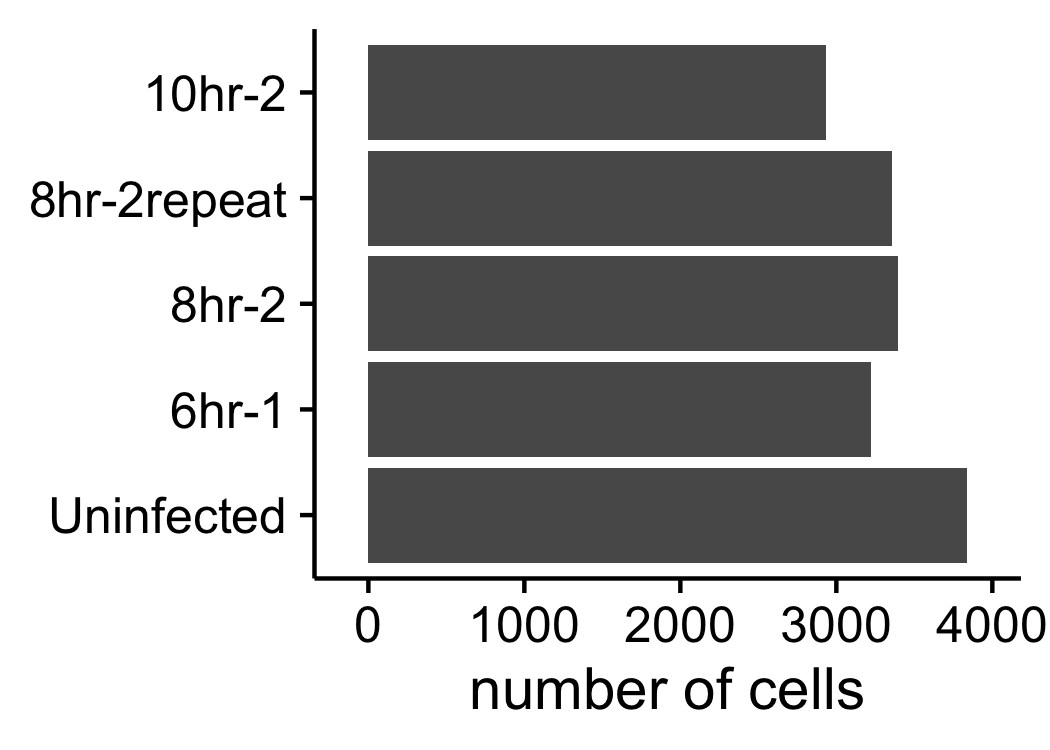

In [3]:
samples <- c("Uninfected", "6hr-1", "8hr-2", "8hr-2repeat", "10hr-2")
cells <- all.cells[, row.names(subset(pData(all.cells), Sample %in% samples))]

p.ncells <- ggplot(
    pData(cells) %>% transform(Sample=factor(Sample, samples)) %>% arrange(Sample), 
    aes(Sample)) + 
  scale_y_continuous(name="number of cells", expand=c(0.09, 0)) + geom_bar() + 
  scale_x_discrete(name=NULL) + coord_flip()

plotfile <- file.path(plotsdir, "ncells_per_sample.png")
ggsave(plotfile, plot=p.ncells, width=3.5, height=2.5, units="in")
display_png(file=plotfile, width=350)

Compute the number of total mRNAs, cellular mRNAs, influenza mRNAs, and fraction of influenza mRNAs per cell.
Then plot a cumulative distribution plot of the fraction of mRNAs that are from influenza for each sample.

In [ ]:
pData(cells)$total.mRNAs <- Matrix::colSums(exprs(cells))

flugenes <- c("fluPB2", "fluPB1", "fluPA", "fluHA", "fluNP", "fluNA", "fluM", "fluNS")
flugenes.id <- row.names(subset(fData(cells), gene_short_name %in% flugenes))
pData(cells)$flu.mRNAs <- Matrix::colSums(exprs(cells[flugenes.id,]))

cellgenes.id <- row.names(subset(fData(cells), !(gene_short_name %in% flugenes)))
pData(cells)$cellular.mRNAs <- Matrix::colSums(exprs(cells[cellgenes.id,]))

pData(cells)$frac.flu.mRNAs <- pData(cells)$flu.mRNAs / pData(cells)$total.mRNAs

# some trickery around x minimum to avoid taking log of 0 
minx <- 1e-4 # minimum value on y-axis
pData(cells)$log.frac.flu <- ifelse(pData(cells)$frac.flu.mRNAs < minx, log10(minx), 
  log10(pData(cells)$frac.flu.mRNAs))

p.cumul <- ggplot(
    transform(pData(cells), Sample=factor(Sample, samples)), # order by sample 
    aes(log.frac.flu, color=Sample)) +
  stat_ecdf() +
  scale_x_continuous(labels=function(x){fancy_scientific(10**x)},
    limits=c(log10(minx), 0), expand=c(0, 0), name="fraction mRNA from influenza") +
  scale_y_continuous(limits=c(0, 1), name="fraction of cells") + 
  theme(axis.text.x=element_text(vjust=0.2))

plotfile <- file.path(plotsdir, "mRNAs_per_cell_cumul.png")
ggsave(plotfile, plot=p.cumul, width=4, height=2.5, units="in")
display_png(file=plotfile, width=400)

Plot the number of influenza mRNAs versus the number of cellular RNAs.
The blue curves show the overall density of the number of cellular mRNAs.
Note that different samples were sequenced to somewhat different depths.

In [ ]:
scatterplot <- ggplot(
    transform(pData(cells), Sample=factor(Sample, levels=samples)), # order by sample
    aes(cellular.mRNAs, flu.mRNAs)) +
  geom_point()

# use eval substitute to get value of maxy as here: https://stackoverflow.com/a/10659563
densityplot <- eval(substitute(
  {stat_density(aes(x=cellular.mRNAs, y=maxy*(..scaled..)), geom="line", color='blue')},
  list(maxy=layer_scales(scatterplot)$y$range$range[2])))

p.flu.vs.cell <- scatterplot + densityplot + 
  theme(axis.text.x=element_text(angle=90, vjust=0.5, hjust=1)) +
  facet_wrap(~Sample, nrow=1) + xlab("cellular mRNAs per cell") + ylab("influenza\nmRNAs per cell")

plotfile <- file.path(plotsdir, "mRNA_counts_flu_vs_cellular.png")
ggsave(plotfile, plot=p.flu.vs.cell, width=9, height=2.5, units="in")
display_png(file=plotfile, width=900)

The `Monocle` vignette suggests filtering cells with far more / less mRNAs than most cells.
I have **not** done that because it filters out a lot of the influenza-infected cells.
This fact is made more clear by the next plot, which shows that cells with >1% of their mRNAs from influenza tend to have more total mRNAs than other cells.
I can think of several possible explanations:

  1. Influenza preferentially infects bigger cells.

  2. Influenza infection leads cells to produce more mRNAs.

  2. Influenza infection preferentially causes "doublets"" due to cell clumping, perhaps mediated by hemagglutinin-based cross-linking of cells.

In any case, it seems safer **not** to exclude the influenza-infected cells as we'd then be preferentially excluded cells with high viral burden.

In [ ]:
pData(cells)$frac.flu.0.01 <- ifelse(pData(cells)$frac.flu.mRNAs > 0.01,
  "more than 1%", "less than 1%")

p.mRNA.density <- ggplot(
    transform(pData(cells), Sample=factor(Sample, samples)), 
    aes(total.mRNAs, color=frac.flu.0.01, fill=frac.flu.0.01)) +
  geom_density(alpha=0.1, aes(y=..scaled..)) +
  theme(axis.text.x=element_text(angle=90, vjust=0.5, hjust=1), legend.position="top") +
  scale_y_continuous(label=NULL, name="density of cells", breaks=NULL, limits=c(0, NA)) +
  scale_x_continuous(limits=c(0, NA)) +
  xlab("total mRNAs per cell") +
  labs(color="mRNAs from influenza:", fill="mRNAs from influenza:") +
  facet_wrap(~Sample, nrow=1, scales="free_y")

plotfile <- file.path(plotsdir, "mRNAs_per_cell.png")
ggsave(plotfile, plot=p.mRNA.density, width=9, height=3, units="in")
display_png(file=plotfile, width=900)

Make a summary plot merging all of these panels. 
This is designed to be a publication-quality figure.

In [ ]:
p.cell.mRNA.summary <- plot_grid(
  plot_grid(p.ncells, p.cumul, ncol=2, align='h', labels=c("A", "B"), label_size=16,
    vjust=-0.2, scale=0.9),
  plot_grid(p.flu.vs.cell, p.mRNA.density, ncol=1, align='v', labels=c("C", "D"),
    rel_heights=c(1, 1.25), label_size=16, scale=0.95),
  ncol=1, rel_heights=c(1, 2.7)
  )

plotfile <- file.path(plotsdir, 'cell_mRNA_summary_fig.png')
ggsave(plotfile, plot=p.cell.mRNA.summary, width=9, height=8, units="in")
display_png(file=plotfile, width=800)

## Look at levels of influenza genes, using synonymous barcodes to detect true infection / co-infection versus mRNA leakage
Roughly half of the infecting influenza viruses had a synonymous barcode at the 3' end of each mRNA.
If cells infected by a single virus (which we expect to be the most common case for infected cells since infection itself is rare), then they should generally have either all wildtype or all synonymously barcoded viruses.
Looking for deviations from this expectation can identify both true infection / co-infection and cells that just got some influenza mRNA by leakage, since such leakage is expected to introduce a mix of both wildtype and synonymously barcoded.
Establishing when cells start to have influenza mRNA due to true infection versus simple leakage is important for figuring out the actual variation in influenza mRNA levels in truly infected cells.

Note that we have counted influenza mRNAs from the standard 10X sequencing of the full transcriptome.
However, we have also called the synonymous versus wildtype barcodes using some extra semi-specific PCR which is not included in the cell-gene count data due to the fact that it is biased towards some genes, but does provide extra depth on the barcode counts.
We limit the analysis below to cells that meet the following criteria:

  1. They have at least two influenza reads in the cell-gene matrix.

  2. They have at least two called barcodes (synonymous or wildtype) in the cell-gene matrix plus extra semi-specific PCR.

These criteria are a way to limit the analysis just to cells where there is actual information about the synonymous barcodes.
First, we filter down to these cells and plot some information about them.
Note that these plots show the number of influenza mRNAs on a log scale, and then color the bars by the fraction of reads from each barcode.
So the heights of each color in the bars are proportional to the fraction of the reads with that barcode, they are **not** the log of the number of reads with each barcode.

In [ ]:
# filter on sufficiently barcoded cells and samples with such cells
bc.cells <- filter(pData(cells), flu.mRNAs >= 2, flu.wt + flu.syn >= 2)
samples.to.plot <- bc.cells[["Sample"]] %>% unlist %>% unique

# make variables with product of log flu mRNAs times fraction with each barcode
bc.cells <- bc.cells %>% mutate(frac.wt=(flu.wt / (flu.wt + flu.syn))) %>%
  mutate(wildtype=log10(flu.mRNAs) * frac.wt, 
    synonymous=log10(flu.mRNAs) * (1 - frac.wt)) %>%
  mutate(major=pmax(wildtype, synonymous), minor=pmin(wildtype, synonymous))

# make some dummy rows with 0 or many influenza to "pad" between samples on the plot
npad <- 5 # pad this many cells on each side of each sample
bc.cells.padded <- lapply(samples.to.plot, function(s) {data.frame(Sample=rep(s , 2 * npad), 
    flu.mRNAs=c(rep(0, npad), rep(1e8, npad)))}) %>%
  bind_rows(., bc.cells) %>% mutate_each(funs(replace(., is.na(.), 0)))

# order bc_cells by sample and flu abundance
bc.cells.padded$Sample <- factor(bc.cells.padded$Sample, samples.to.plot)
bc.cells.padded <- arrange(bc.cells.padded, Sample, flu.mRNAs)
bc.cells.padded$indx <- as.numeric(row.names(bc.cells.padded))

# get min and max indx for each sample
indxrange <- bc.cells.padded %>% filter(major > 0) %>% group_by(Sample) %>% 
  summarize(imax=max(indx), imin=min(indx)) %>%
  mutate(center=(imin + imax) / 2, label=sprintf("%s\n(%d cells)", Sample, imax - imin + 1))

purityplot <- function (barcodes) {
  # plot purity of barcoded cells using barcode type specified by *barcodes*
  ggplot(melt(bc.cells.padded, id.vars=c("indx", "Sample"), measure.vars=barcodes, 
      variable.name="barcode"),
    aes(x=indx, y=value)) +
  geom_bar(aes(fill=barcode), stat="identity", position="stack", width=1) +
  scale_y_continuous(name="influenza mRNAs", expand=c(0, 0), 
    labels=function(y){fancy_scientific(10**y)}) +
  scale_x_continuous(expand=c(0, 0), name=NULL, breaks=indxrange$center, labels=indxrange$label) +
  theme(axis.ticks.x=element_blank(), legend.position=c(0, 1),
    legend.justification=c(0, 1), legend.direction="horizontal",
    legend.background=element_rect(fill="white", size=0.5, linetype="solid", color="black")) +
  scale_fill_discrete("") +
  geom_rect(data=data.frame(xmin=indxrange$imin[seq(2, nrow(indxrange), 2)] - npad,
    xmax=indxrange$imax[seq(2, nrow(indxrange), 2)] + npad, ymin=-Inf, ymax=Inf),
    aes(xmin=xmin, xmax=xmax, ymin=ymin, ymax=ymax), alpha=0.1, inherit.aes=FALSE)
}

p.wt.syn <- purityplot(c("wildtype", "synonymous"))
p.major.minor <- purityplot(c("major", "minor"))
p.barcode.purity <- plot_grid(p.wt.syn + theme(axis.text.x=element_blank()),
  p.major.minor + scale_fill_manual(values=c("darkmagenta", "gold"), name=NULL),
  nrow=2, align='h', labels=c("A", "B"), label_size=16, vjust=1)

plotfile <- file.path(plotsdir, "flu_barcode_purity.png")
ggsave(plotfile, plot=p.barcode.purity, width=9, height=4.7, units="in")
display_png(file=plotfile, width=900)

Now let's try to find a good cutoff for the fraction of influenza reads per cell that seems to indicate true infection rather than co-infection.
To do this, we continue to subset on the cells with at least 2 influenza reads and 2 called wildtype / synonymous barcodes.
For each fraction of influenza reads per cell, we then calculate the mean barcode purity in cells with > this fraction of influenza reads. 
The goal is to find a lowest cutoff at which higher fraction of influenza reads doesn't lead to substantially higher purity.
This indicates that we have reached the point where most of the mixing that we are detecting is due to true co-infection, rather than cells that simply have "leaked" influenza reads.

Looking at the plots above, it's clear that the cutoff should be higher for the samples with more influenza infection, since those samples clearly have more leakage. 
However, to be conservative we compute a cutoff using the sample with the **most** influenza mRNAs in infected cells (this sample will have the most leakage and so the highest cutoff), and then apply this cutoff to all samples.
This approach is conservative in the sense that we are making the cutoff a bit higher than needed for the lower-influenza samples.
However, this seems safer than estimating a different cutoff for each sample, as the lower number of cells with multiple barcoded mRNAs for the lower-influenza samples makes it harder to estimate a reliable cutoff for these samples.

In [ ]:
# get the sample with the most flu positive cells, compute purity cutoff on it
sample.most.flu <- bc.cells %>% group_by(Sample) %>% summarise(cells=n()) %>% 
  arrange(cells) %>% tail(n=1) %>% .$Sample %>% sprintf("%s", .) 
cat("Computing purity cutoff for sample with most influenza,", sample.most.flu)
bc.cells <- filter(bc.cells, Sample == sample.most.flu)

# compute purity to only out this far, as curve has flattened by about 50th percentile
frac.flu <- bc.cells$frac.flu.mRNAs %>% sort %>% head(-as.integer(0.35 * nrow(bc.cells)))

# mean of major barcode frequency with cells <= indication fraction flu
bc.cells <- mutate(bc.cells, purity=pmax(wildtype, synonymous) / (wildtype + synonymous))
purity <- data.frame(frac.flu)
purity$mean <- lapply(frac.flu, function (f) {bc.cells %>% filter(frac.flu.mRNAs > f) %>% 
  select(purity) %>% as.vector %>% unlist %>% mean}) %>% unlist

# threshold where derivative of purity with respect to fraction flu stops being positive
deriv.purity <- loess(mean~frac.flu, data=purity) %$% fitted %>% diff
i.threshold <- which(deriv.purity < 0) %>% min  
threshold.frac <- frac.flu[i.threshold]

# plot the data, smoothed loess fit, and threshold line
p.purity.threshold <- ggplot(purity, 
    aes(x=frac.flu, y=mean)) + geom_point(size=1, alpha=0.2) + 
  geom_smooth(method='loess') +
  scale_y_continuous(name="mean purity", 
    limits=c(min(purity$mean), max(purity$mean))) +
  scale_x_continuous(name=sprintf("min frac influenza (%s)", sample.most.flu), 
    labels=fancy_scientific, breaks=pretty_breaks(n=2)) +
  theme(axis.text.x=element_text(vjust=0.2)) +
  geom_vline(xintercept=threshold.frac, color="red", linetype="dashed") + 
  geom_text(aes(threshold.frac, mean(c(min(purity$mean), max(purity$mean))), 
      label=fancy_scientific(threshold.frac, parse.str=FALSE, digits=2), hjust=-0.05), 
    parse=TRUE, color="red")

plotfile <- file.path(plotsdir, "flu_purity_cutoff.png")
ggsave(plotfile, plot=p.purity.threshold, width=4, height=3, units="in")
display_png(file=plotfile, width=300)

Now we can annotate cells as *infected* based on whether they have more than this threshold fraction of reads from influenza.

We also annotate cells as *coinfected* if they have **both**:

  1. More than the threshold fraction of reads from their minor barcode (where the threshold fraction is defined as the above amount giving the fraction of influenza reads needed to consider that we have a "true" infection).
  2. More than 5% of their barcoded influenza reads from their minor barcode. 
  
Note that we do not expect to identify all of the co-infected cells. 
Even if the wildtype and synonymously barcoded viruses are mixed at exactly equal ratios, we expect half of the co-infected cells to receive two of the same virus barcode, and so be undetectably co-infected.

Below we tabulate the number of cells in each category.

We then plot the distribution of influenza reads per cell in among the clearly co-infected cells for each sample.

Finally, we merge these plots / tables with the ones aboved used to call infection / co-infection into a publication-quality figure.

In [ ]:
# annotate cells as infected or coinfected
pData(cells) <- pData(cells) %>% mutate(infected=frac.flu.mRNAs > threshold.frac) %>%
  mutate(minor=pmin(flu.wt, flu.syn) / (flu.wt + flu.syn)) %>%
  mutate(minor=ifelse(is.na(minor), 0, minor)) %>%
  mutate(n.minor=minor * flu.mRNAs) %>% 
  mutate(coinfected=(infected & (minor > 0.05) & (minor * frac.flu.mRNAs > threshold.frac)))

# summarize number of cells in each category by sample
infected.summary <- pData(cells) %>% group_by(Sample) %>% 
  summarise(cells=n(), infected=sum(infected), coinfected=sum(coinfected)) %>%
  mutate(coinfected=ifelse(is.na(coinfected), 0, coinfected)) %>% 
  transform(Sample=factor(Sample, samples)) %>% arrange(Sample) 

# plot number of infected / co-infected cells
xlabeler <- function(x) {ifelse(x%%1, sprintf("%.1f", x), sprintf("%d", x))}
p.frac.flu <- ggplot(
    pData(cells) %>% filter(infected) %>%  
      mutate(infection=ifelse(coinfected, "coinfected", "infected")) %>%
      transform(infection=factor(infection, c("infected", "coinfected")),
        Sample=factor(Sample, samples)) %>% 
      arrange(Sample, infection), 
    aes(frac.flu.mRNAs, fill=infection)) + 
  geom_histogram(bins=18) + facet_wrap(~Sample, nrow=1) + scale_fill_discrete("") +
  scale_y_continuous(name="number of cells") + 
  scale_x_continuous(name="fraction mRNA from influenza", labels=xlabeler, expand=c(0.1, 0))

# blank to fill space
blank <- ggplot() + geom_blank(aes(1,1)) + theme_nothing()

# layout in one nice figure
p.frac.flu.summary <- plot_grid(
  p.barcode.purity, 
  plot_grid(p.purity.threshold, blank, infected.summary %>% tableGrob(rows=NULL), scale=0.93, 
    labels=c("C", "", "D"), label_size=16, vjust=1, nrow=1, rel_widths=c(0.8, 0.25, 1)), 
  p.frac.flu,
  labels=c("", "", "E"), label_size=16, vjust=1, ncol=1, 
  rel_heights=c(1, 0.51, 0.48), scale=0.97)

plotfile <- file.path(plotsdir, 'frac_flu_summary_fig.png')
ggsave(plotfile, plot=p.frac.flu.summary, width=9, height=9.5, units="in")
display_png(file=plotfile, width=800)